In [1]:
# Cell 1: Imports and setup
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots appear in the notebook
%matplotlib inline

print("Environment ready! 🚀")

Environment ready! 🚀


In [2]:
# Cell 2: Load the dataset
print("Loading Amazon Reviews dataset...")
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", 
                      "raw_review_All_Beauty", 
                      trust_remote_code=True)

df = dataset['full'].to_pandas()
print(f"Loaded {len(df)} reviews!")
df.head()

Loading Amazon Reviews dataset...
Loaded 701528 reviews!


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [3]:
# Cell 3: Quick exploration
print("Dataset shape:", df.shape)
print("\nRating distribution:")
df['rating'].value_counts().sort_index()

Dataset shape: (701528, 10)

Rating distribution:


rating
1.0    102080
2.0     43034
3.0     56307
4.0     79381
5.0    420726
Name: count, dtype: int64

In [4]:
# Most common words (basic analysis)
from collections import Counter
import re

def clean_text_basic(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""
    # Convert to lowercase, remove special chars, split
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

# Sample analysis on first 1000 reviews for speed
sample_df = df.head(1000).copy()
sample_df['clean_text'] = sample_df['text'].apply(clean_text_basic)

# Most common words
all_words = []
for text in sample_df['clean_text']:
    all_words.extend(text.split())

word_counts = Counter(all_words)
print("Most common words:")
print(word_counts.most_common(20))

Most common words:
[('the', 3560), ('i', 2930), ('and', 2522), ('a', 2386), ('to', 2220), ('it', 2181), ('is', 1736), ('this', 1464), ('of', 1365), ('my', 1341), ('for', 1177), ('in', 988), ('that', 911), ('br', 812), ('with', 767), ('on', 724), ('not', 664), ('are', 659), ('but', 656), ('skin', 655)]


In [6]:
# Check for potential issues
print("Data Quality Checks:")
print("=" * 50)

df['text_length'] = df['text'].str.len()

# 1. Missing text or ratings
print(f"Reviews with missing text: {df['text'].isnull().sum()}")
print(f"Reviews with missing ratings: {df['rating'].isnull().sum()}")

# 2. Invalid ratings
valid_ratings = df['rating'].between(1, 5)
print(f"Invalid ratings: {(~valid_ratings).sum()}")

# 3. Duplicate reviews
duplicates = df.duplicated(subset=['text'], keep=False)
print(f"Potential duplicate reviews: {duplicates.sum()}")

# 4. Empty or very short reviews
empty_reviews = df['text'].str.strip().str.len() < 10
print(f"Very short reviews (< 10 chars): {empty_reviews.sum()}")

# 5. Extremely long reviews (might be spam)
very_long = df['text_length'] > 5000
print(f"Extremely long reviews (> 5000 chars): {very_long.sum()}")

Data Quality Checks:
Reviews with missing text: 0
Reviews with missing ratings: 0
Invalid ratings: 0
Potential duplicate reviews: 70783
Very short reviews (< 10 chars): 27373
Extremely long reviews (> 5000 chars): 76


In [7]:
# Look at examples by rating
print("\nSample 1-star reviews:")
one_star = df[df['rating'] == 1.0]['text'].head(3)
for i, review in enumerate(one_star, 1):
    print(f"{i}. {review[:200]}...")

print("\nSample 5-star reviews:")
five_star = df[df['rating'] == 5.0]['text'].head(3)
for i, review in enumerate(five_star, 1):
    print(f"{i}. {review[:200]}...")


Sample 1-star reviews:
1. Felt synthetic...
2. nothing special  unfortunately i waited too long to return them ....  no results at all  dont waste your money...
3. This halo hair extension is simply put, garbage.  Now, you get what you pay for.  And this is a very cheap version.  The faux hair is very shiny and looks literally like bad barbie hair.  It looks WAY...

Sample 5-star reviews:
1. This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium ...
2. Smells good, feels great!...
3. Love it...


In [8]:
# Create a new notebook cell or section
print("ML Problem Definition:")
print("Input: Review text")
print("Output: Star rating (1-5)")
print("Task: Multi-class classification")

# Check the target distribution
print("\nTarget variable distribution:")
rating_dist = df['rating'].value_counts().sort_index()
print(rating_dist)
print(f"\nClass balance: {(rating_dist / len(df) * 100).round(1)}%")

ML Problem Definition:
Input: Review text
Output: Star rating (1-5)
Task: Multi-class classification

Target variable distribution:
rating
1.0    102080
2.0     43034
3.0     56307
4.0     79381
5.0    420726
Name: count, dtype: int64

Class balance: rating
1.0    14.6
2.0     6.1
3.0     8.0
4.0    11.3
5.0    60.0
Name: count, dtype: float64%


In [9]:
uv add scikit-learn

/home/daniel/review-predictor/.venv/bin/python: No module named uv
Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.model_selection import train_test_split

# First, let's work with a manageable subset for development
# Start with 10k samples, scale up later
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Working with {len(df_sample)} samples for initial development")

# Create features and target
X = df_sample['text'].copy()
y = df_sample['rating'].copy()

# Split the data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples") 
print(f"Test set: {len(X_test)} samples")

# Verify class distribution is maintained
print("\nClass distribution in splits:")
for split_name, split_y in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    dist = split_y.value_counts(normalize=True).sort_index() * 100
    print(f"{split_name}: {dict(dist.round(1))}")

Working with 10000 samples for initial development
Train set: 7004 samples
Validation set: 1496 samples
Test set: 1500 samples

Class distribution in splits:
Train: {1.0: np.float64(14.6), 2.0: np.float64(6.1), 3.0: np.float64(7.9), 4.0: np.float64(11.5), 5.0: np.float64(60.0)}
Val: {1.0: np.float64(14.6), 2.0: np.float64(6.1), 3.0: np.float64(8.0), 4.0: np.float64(11.4), 5.0: np.float64(60.0)}
Test: {1.0: np.float64(14.5), 2.0: np.float64(6.1), 3.0: np.float64(7.9), 4.0: np.float64(11.5), 5.0: np.float64(60.0)}


In [13]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def preprocess_text(text):
    """
    Basic text preprocessing function
    Start simple, add complexity as needed
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Optional: Remove URLs, emails, etc.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    return text

# Apply preprocessing
print("Preprocessing text...")
X_train_clean = X_train.apply(preprocess_text)
X_val_clean = X_val.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

print("Sample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal: {X_train.iloc[i][:100]}...")
    print(f"Cleaned:  {X_train_clean.iloc[i][:100]}...")

Preprocessing text...
Sample preprocessed texts:

Original: [[VIDEOID:566878dfca8b441b87394548f4602b79]] Love the unit Added bundles to make fuller to my liking...
Cleaned:  [[videoid:566878dfca8b441b87394548f4602b79]] love the unit added bundles to make fuller to my liking...

Original: [[VIDEOID:9cf1d81157facf7dfbbca7e500f3a58b]] I got all of them 😂 1 is hidden. Each pack got 2 inside...
Cleaned:  [[videoid:9cf1d81157facf7dfbbca7e500f3a58b]] i got all of them 😂 1 is hidden. each pack got 2 inside...

Original: I love the feel and the smell of this hand cream. It really softens my hands and eleminates winter’s...
Cleaned:  i love the feel and the smell of this hand cream. it really softens my hands and eleminates winter’s...


In [14]:
print('test')

test


In [15]:
# Set up TF-IDF vectorizer for baseline model
vectorizer = TfidfVectorizer(
    max_features=5000,      # Start with 5k features
    stop_words='english',   # Remove common words
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=2,               # Ignore terms appearing in < 2 documents
    max_df=0.95             # Ignore terms appearing in > 95% of documents
)

# Fit only on training data
print("Fitting TF-IDF vectorizer...")
X_train_vectors = vectorizer.fit_transform(X_train_clean)
X_val_vectors = vectorizer.transform(X_val_clean)
X_test_vectors = vectorizer.transform(X_test_clean)

print(f"Feature matrix shape: {X_train_vectors.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# Look at some features
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")

Fitting TF-IDF vectorizer...
Feature matrix shape: (7004, 5000)
Vocabulary size: 5000

Sample features: ['00' '10' '10 10' '10 days' '10 minutes' '10 recommend' '10 stars' '100'
 '100 human' '10x' '11' '12' '13' '14' '15' '15 years' '16' '17' '18' '19']


In [17]:
# For most algorithms, we can use ratings directly
# But let's also prepare a binary version for experimentation

# Multi-class target (1-5 stars)
y_train_multi = y_train.copy()
y_val_multi = y_val.copy()
y_test_multi = y_test.copy()

# Binary target (positive vs negative sentiment)
# 1-2 stars = negative (0), 4-5 stars = positive (1), ignore 3 stars
def convert_to_binary(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating >= 4:
        return 1  # Positive
    else:
        return None  # Neutral - we'll filter these out

# Create binary datasets
binary_mask_train = y_train.apply(lambda x: convert_to_binary(x) is not None).values
binary_mask_val = y_val.apply(lambda x: convert_to_binary(x) is not None).values
binary_mask_test = y_test.apply(lambda x: convert_to_binary(x) is not None).values

y_train_binary = y_train[y_train.apply(lambda x: convert_to_binary(x) is not None)].apply(convert_to_binary)
y_val_binary = y_val[y_val.apply(lambda x: convert_to_binary(x) is not None)].apply(convert_to_binary)
y_test_binary = y_test[y_test.apply(lambda x: convert_to_binary(x) is not None)].apply(convert_to_binary)

X_train_vectors_binary = X_train_vectors[binary_mask_train]
X_val_vectors_binary = X_val_vectors[binary_mask_val]
X_test_vectors_binary = X_test_vectors[binary_mask_test]

print(f"Multi-class dataset: {len(y_train_multi)} train samples")
print(f"Binary dataset: {len(y_train_binary)} train samples")
print(f"Binary class distribution: {y_train_binary.value_counts().to_dict()}")

Multi-class dataset: 7004 train samples
Binary dataset: 6449 train samples
Binary class distribution: {1: 5003, 0: 1446}


In [18]:
import pickle
import os

# Create a data directory
os.makedirs('data/processed', exist_ok=True)

# Save the preprocessed data
data_to_save = {
    'X_train_vectors': X_train_vectors,
    'X_val_vectors': X_val_vectors,
    'X_test_vectors': X_test_vectors,
    'y_train_multi': y_train_multi,
    'y_val_multi': y_val_multi,
    'y_test_multi': y_test_multi,
    'X_train_vectors_binary': X_train_vectors_binary,
    'X_val_vectors_binary': X_val_vectors_binary,
    'X_test_vectors_binary': X_test_vectors_binary,
    'y_train_binary': y_train_binary,
    'y_val_binary': y_val_binary,
    'y_test_binary': y_test_binary,
    'vectorizer': vectorizer,
    'original_text_train': X_train,
    'original_text_val': X_val,
    'original_text_test': X_test
}

with open('data/processed/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Preprocessed data saved to 'data/processed/preprocessed_data.pkl'")
print("\nReady for model training! 🎯")

Preprocessed data saved to 'data/processed/preprocessed_data.pkl'

Ready for model training! 🎯


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Start with binary classification (easier to interpret)
print("Training Logistic Regression for Binary Classification (Positive vs Negative)")
print("=" * 60)

# Initialize the model
lr_binary = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Increase iterations for convergence
    C=1.0           # Regularization strength (lower = more regularization)
)

# Train the model
print("Training...")
lr_binary.fit(X_train_vectors_binary, y_train_binary)

# Make predictions
y_val_pred_binary = lr_binary.predict(X_val_vectors_binary)
y_val_prob_binary = lr_binary.predict_proba(X_val_vectors_binary)

# Evaluate performance
accuracy = accuracy_score(y_val_binary, y_val_pred_binary)
print(f"Validation Accuracy: {accuracy:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_val_binary, y_val_pred_binary, 
                          target_names=['Negative (1-2★)', 'Positive (4-5★)']))

Training Logistic Regression for Binary Classification (Positive vs Negative)
Training...
Validation Accuracy: 0.875

Detailed Classification Report:
                 precision    recall  f1-score   support

Negative (1-2★)       0.91      0.50      0.64       309
Positive (4-5★)       0.87      0.99      0.92      1068

       accuracy                           0.88      1377
      macro avg       0.89      0.74      0.78      1377
   weighted avg       0.88      0.88      0.86      1377



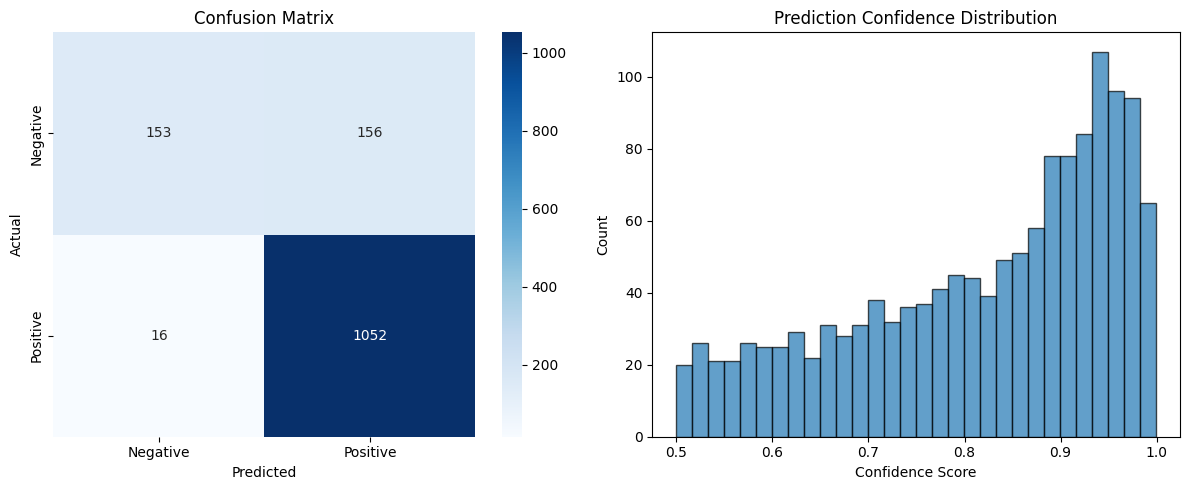

Average prediction confidence: 0.818


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val_binary, y_val_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Prediction Confidence Distribution
plt.subplot(1, 2, 2)
# Get confidence scores (max probability)
confidence_scores = np.max(y_val_prob_binary, axis=1)
plt.hist(confidence_scores, bins=30, alpha=0.7, edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Average prediction confidence: {confidence_scores.mean():.3f}")

Top 15 features for POSITIVE sentiment:
                feature  coefficient
792             comfort     0.000666
1522            feature    -0.000630
93         additionally     0.000624
138                alot    -0.000567
633               catch    -0.000563
1540        feels great     0.000541
3128            patient     0.000507
839           confident    -0.000484
3080       package came    -0.000437
3470  quality synthetic     0.000362
1921       hair getting    -0.000341
1464          face mask    -0.000221
1154           dispense    -0.000093
1049         deodorants     0.000042
4175           stoppers     0.000000

Top 15 features for NEGATIVE sentiment:
           feature  coefficient
2631          love     6.332045
1809         great     6.230838
1136  disappointed    -4.100808
3151       perfect     3.972818
2933          nice     3.400440
4791         waste    -3.235601
4922         works     3.186579
1092          didn    -3.182001
1073           did    -2.989685
3633   

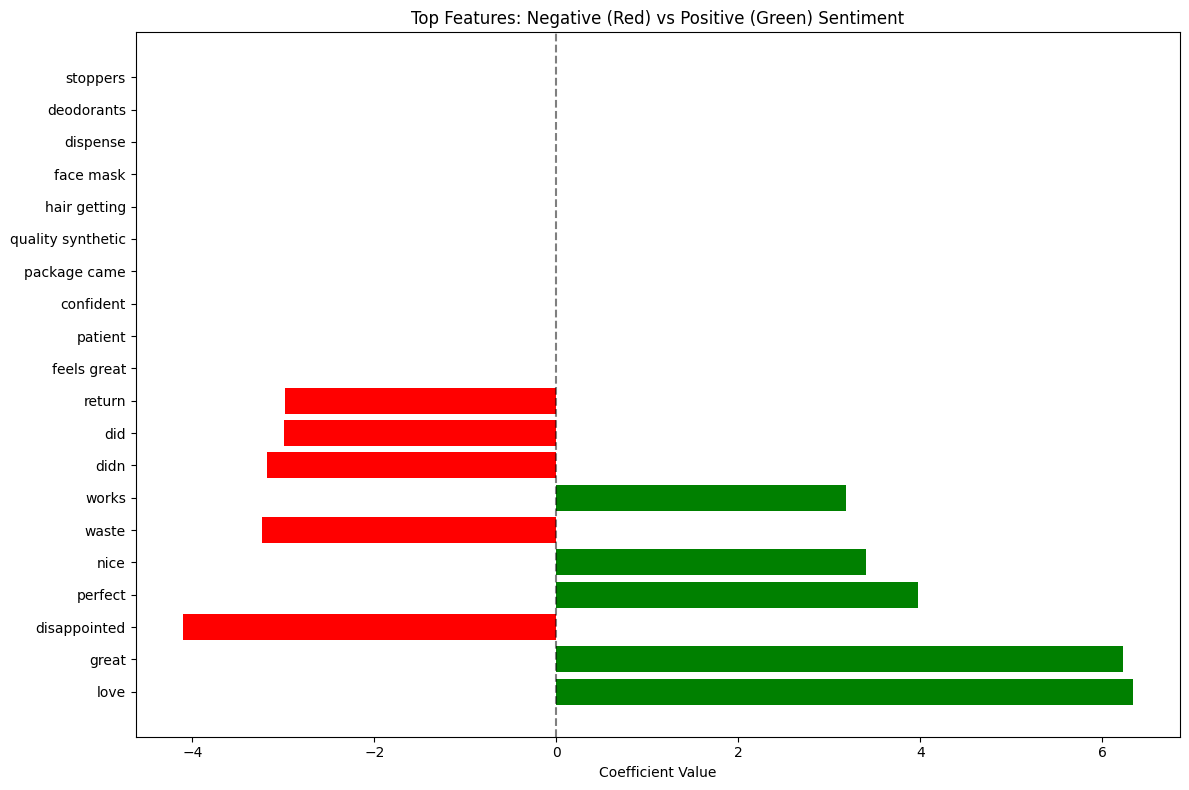

In [21]:
# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = lr_binary.coef_[0]

# Create a dataframe for easier analysis
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', key=abs, ascending=False)

print("Top 15 features for POSITIVE sentiment:")
positive_features = feature_importance.tail(15)
print(positive_features[['feature', 'coefficient']])

print("\nTop 15 features for NEGATIVE sentiment:")
negative_features = feature_importance.head(15)
print(negative_features[['feature', 'coefficient']])

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = pd.concat([negative_features.head(10), positive_features.tail(10)])

plt.barh(range(len(top_features)), top_features['coefficient'], 
         color=['red' if x < 0 else 'green' for x in top_features['coefficient']])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top Features: Negative (Red) vs Positive (Green) Sentiment')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [22]:
def predict_sentiment(text, model, vectorizer):
    """Test the model on a single review"""
    # Preprocess the text (same as training)
    clean_text = preprocess_text(text)
    
    # Vectorize
    text_vector = vectorizer.transform([clean_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]
    
    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = max(probability)
    
    return sentiment, confidence

# Test some examples
test_reviews = [
    "This product is absolutely amazing! I love it so much!",
    "Terrible quality, completely broke after one day. Waste of money.",
    "It's okay, nothing special but does the job.",
    "Outstanding customer service and fast shipping. Highly recommend!",
    "Cheap plastic, looks nothing like the pictures. Very disappointed."
]

print("Testing Individual Predictions:")
print("=" * 50)
for review in test_reviews:
    sentiment, confidence = predict_sentiment(review, lr_binary, vectorizer)
    print(f"Review: {review[:50]}...")
    print(f"Prediction: {sentiment} (confidence: {confidence:.3f})")
    print()

Testing Individual Predictions:
Review: This product is absolutely amazing! I love it so m...
Prediction: Positive (confidence: 0.965)

Review: Terrible quality, completely broke after one day. ...
Prediction: Negative (confidence: 0.985)

Review: It's okay, nothing special but does the job....
Prediction: Positive (confidence: 0.712)

Review: Outstanding customer service and fast shipping. Hi...
Prediction: Positive (confidence: 0.946)

Review: Cheap plastic, looks nothing like the pictures. Ve...
Prediction: Negative (confidence: 0.904)



Training Logistic Regression for Multi-Class Classification (1-5 stars)
Multi-class Validation Accuracy: 0.672

Detailed Classification Report:
              precision    recall  f1-score   support

         1.0       0.66      0.52      0.58       218
         2.0       0.00      0.00      0.00        91
         3.0       0.31      0.03      0.06       119
         4.0       0.18      0.02      0.03       171
         5.0       0.69      0.99      0.81       897

    accuracy                           0.67      1496
   macro avg       0.36      0.31      0.30      1496
weighted avg       0.55      0.67      0.58      1496



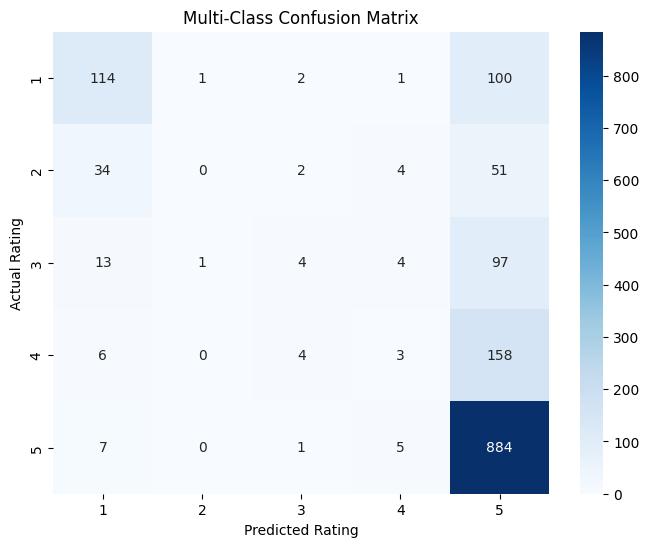

In [25]:
print("Training Logistic Regression for Multi-Class Classification (1-5 stars)")
print("=" * 70)
from sklearn.multiclass import OneVsRestClassifier

# Train multi-class model
lr_multi = OneVsRestClassifier(LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0  # One-vs-Rest for multi-class
))

lr_multi.fit(X_train_vectors, y_train_multi)

# Predict
y_val_pred_multi = lr_multi.predict(X_val_vectors)

# Evaluate
accuracy_multi = accuracy_score(y_val_multi, y_val_pred_multi)
print(f"Multi-class Validation Accuracy: {accuracy_multi:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_val_multi, y_val_pred_multi))

# Confusion matrix for multi-class
plt.figure(figsize=(8, 6))
cm_multi = confusion_matrix(y_val_multi, y_val_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Multi-Class Confusion Matrix')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.show()